In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss, Conv2d, Sequential, BatchNorm2d
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchinfo import summary

from ActiveShiftLayer import ASL
from util import test_loss, train_NN

from ray import tune
from ray.tune.examples.mnist_pytorch import get_data_loaders, ConvNet, train, test

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
torch.__version__

'1.11.0+cu113'

In [4]:
batch_size = 100

#transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [7]:
def train_mnist(config):
    train_loader, test_loader = get_data_loaders()
    model = ConvNet()
    optimizer = optim.SGD(model.parameters(), lr=config["lr"])
    for i in range(5):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)
        print(f"ACC: {acc}")
        print(config)
        tune.report(mean_accuracy=acc)


analysis = tune.run(
    train_mnist, config={"lr": tune.loguniform(0.001, 0.01, 0.1)}, num_samples=10)

print("Best config: ", analysis.get_best_config(metric="mean_accuracy", mode="max"))

# Get a dataframe for analyzing trial results.
df = analysis.dataframe()

Trial name,status,loc,lr,acc,iter,total time (s)
train_mnist_b4eb3_00000,TERMINATED,129.206.61.139:53910,0.00431087,0.228125,5,1.2231
train_mnist_b4eb3_00001,TERMINATED,129.206.61.139:53939,0.00499229,0.203125,5,0.894659
train_mnist_b4eb3_00002,TERMINATED,129.206.61.139:53941,0.00367694,0.284375,5,0.961146
train_mnist_b4eb3_00003,TERMINATED,129.206.61.139:53943,0.00122217,0.153125,5,0.870768
train_mnist_b4eb3_00004,TERMINATED,129.206.61.139:53945,0.00146656,0.071875,5,0.927457
train_mnist_b4eb3_00005,TERMINATED,129.206.61.139:53951,0.00434247,0.259375,5,0.829095
train_mnist_b4eb3_00006,TERMINATED,129.206.61.139:53952,0.00779825,0.509375,5,0.819049
train_mnist_b4eb3_00007,TERMINATED,129.206.61.139:53955,0.00158676,0.115625,5,0.99225
train_mnist_b4eb3_00008,TERMINATED,129.206.61.139:53957,0.00208243,0.26875,5,0.852505
train_mnist_b4eb3_00009,TERMINATED,129.206.61.139:53962,0.00905864,0.14375,5,0.898575


Result for train_mnist_b4eb3_00000:
  date: 2022-08-26_12-34-49
  done: false
  experiment_id: 05f1ebfaef07472084bfd8ee9bcb1054
  hostname: max-Latitude-5401
  iterations_since_restore: 1
  mean_accuracy: 0.14375
  node_ip: 129.206.61.139
  pid: 53910
  time_since_restore: 0.2561607360839844
  time_this_iter_s: 0.2561607360839844
  time_total_s: 0.2561607360839844
  timestamp: 1661510089
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b4eb3_00000
  warmup_time: 0.0023970603942871094
  
(train_mnist pid=53910) ACC: 0.14375
(train_mnist pid=53910) {'lr': 0.00431087336827088}
(train_mnist pid=53910) ACC: 0.153125
(train_mnist pid=53910) {'lr': 0.00431087336827088}
(train_mnist pid=53910) ACC: 0.175
(train_mnist pid=53910) {'lr': 0.00431087336827088}
(train_mnist pid=53910) ACC: 0.196875
(train_mnist pid=53910) {'lr': 0.00431087336827088}
(train_mnist pid=53910) ACC: 0.228125
(train_mnist pid=53910) {'lr': 0.00431087336827088}
Result for train_mnist_b4eb3_00000:
  date: 20

2022-08-26 12:34:53,612	INFO tune.py:758 -- Total run time: 6.36 seconds (6.23 seconds for the tuning loop).


(train_mnist pid=53955) ACC: 0.115625
(train_mnist pid=53955) {'lr': 0.001586755630030104}
Best config:  {'lr': 0.007798254521070607}


In [15]:
from Models import LeASLNet

input_shape = (batch_size, 1, 28, 28)


LeASLNN = LeASLNet(input_shape, 10, device, expansion_rate=1)

summary(LeASLNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─CSC_block: 2-5                    [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        108
│    │    └─Conv2d: 3-2                  [100, 16, 14, 14]         112
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─T

In [16]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(LeASLNN.parameters(), lr=0.00967098, momentum=0.983901)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.2)

In [7]:
from Models import LeASLNet
input_shape = (batch_size, 1, 28, 28)
criterion = CrossEntropyLoss()

def train_mnist(config):
    train_loader, test_loader = train_dataloader, test_dataloader
    model = LeASLNet(input_shape, 10, device, expansion_rate=1)
    optimizer = optim.SGD(model.parameters(), lr=config["lr"],  momentum=config["momentum"])
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, config["gamma"])
    for i in range(1):
        train_NN(model, train_dataloader,
            test_dataloader, epochs=5, optimizer=optimizer, criterion=criterion,
            scheduler=scheduler, device=device, steps_to_test=200, print_test=True)
        acc = test_loss(model, test_dataloader, criterion, device)[1]
        print(f"ACC: {acc}")
        print(config)
        tune.report(mean_accuracy=acc)


analysis = tune.run(
    train_mnist,num_samples=10, resources_per_trial={
        "cpu": 0,
        "gpu": 1
    },config={"lr": tune.loguniform(0.001, 0.1), "momentum": tune.uniform(0.8, 1), "gamma": tune.uniform(0.5, 0.99)})

print("Best config: ", analysis.get_best_config(metric="mean_accuracy", mode="max",))

# Get a dataframe for analyzing trial results.
df = analysis.dataframe()

Trial name,status,loc,gamma,lr,momentum
train_mnist_885a7_00000,ERROR,127.0.0.1:11556,0.926798,0.00279793,0.999451
train_mnist_885a7_00001,ERROR,127.0.0.1:6880,0.982684,0.00427207,0.873423
train_mnist_885a7_00002,ERROR,127.0.0.1:132,0.719015,0.0520819,0.812765
train_mnist_885a7_00003,ERROR,127.0.0.1:3324,0.960159,0.0932114,0.844859
train_mnist_885a7_00004,ERROR,127.0.0.1:4568,0.60613,0.00527899,0.90326
train_mnist_885a7_00005,ERROR,127.0.0.1:10272,0.611968,0.00583953,0.841387
train_mnist_885a7_00006,ERROR,127.0.0.1:4356,0.534927,0.00197607,0.884031
train_mnist_885a7_00007,ERROR,127.0.0.1:16240,0.669799,0.00265331,0.910228
train_mnist_885a7_00008,ERROR,127.0.0.1:14940,0.530868,0.00205729,0.937113
train_mnist_885a7_00009,ERROR,127.0.0.1:15016,0.569875,0.0534576,0.998498


2022-08-28 17:39:12,410	WARNING worker.py:1829 -- Warning: The actor ImplicitFunc is very large (52 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-08-28 17:39:12,692	WARNING util.py:220 -- The `start_trial` operation took 1.648 s, which may be a performance bottleneck.
(train_mnist pid=11556) 2022-08-28 17:39:22,171	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_mnist pid=11556) Traceback (most recent call last):
(train_mnist pid=11556)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_mnist pid=11556)     self._entrypoint()
(train_mnist pid=11556)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_mnist pid=11556)     return self._trainable_func(
(train_mnist pid=11556)   File "c:\Users\maxhe\anaconda3

Result for train_mnist_885a7_00000:
  date: 2022-08-28_17-39-18
  experiment_id: 9107696b6e9c4ace89c1afacb0b4bbdf
  hostname: DESKTOP-DQJ7FUB
  node_ip: 127.0.0.1
  pid: 11556
  timestamp: 1661701158
  trial_id: 885a7_00000
  


2022-08-28 17:39:23,820	WARNING util.py:220 -- The `start_trial` operation took 0.905 s, which may be a performance bottleneck.
2022-08-28 17:39:32,991	ERROR trial_runner.py:980 -- Trial train_mnist_885a7_00001: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=6880, ip=127.0.0.1, repr=train_mnist)
  File "python\ray\_raylet.pyx", line 662, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 666, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 613, in ray._raylet.execute_task.function_executor
  File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\trainable.py", line 347, 

Result for train_mnist_885a7_00001:
  date: 2022-08-28_17-39-29
  experiment_id: ce8b253a7e2041778bb89beaa0cc319d
  hostname: DESKTOP-DQJ7FUB
  node_ip: 127.0.0.1
  pid: 6880
  timestamp: 1661701169
  trial_id: 885a7_00001
  


2022-08-28 17:39:34,827	WARNING util.py:220 -- The `start_trial` operation took 0.863 s, which may be a performance bottleneck.
(train_mnist pid=132) 2022-08-28 17:39:44,071	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_mnist pid=132) Traceback (most recent call last):
(train_mnist pid=132)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_mnist pid=132)     self._entrypoint()
(train_mnist pid=132)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_mnist pid=132)     return self._trainable_func(
(train_mnist pid=132)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_mnist pid=132)     return method(self, *_args, **_kwargs)
(train_mnist pid=132)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 684, in _tr

Result for train_mnist_885a7_00002:
  date: 2022-08-28_17-39-40
  experiment_id: 026960f84b3a4637a26241b68aff4983
  hostname: DESKTOP-DQJ7FUB
  node_ip: 127.0.0.1
  pid: 132
  timestamp: 1661701180
  trial_id: 885a7_00002
  


2022-08-28 17:39:45,950	WARNING util.py:220 -- The `start_trial` operation took 0.939 s, which may be a performance bottleneck.
2022-08-28 17:39:55,194	ERROR trial_runner.py:980 -- Trial train_mnist_885a7_00003: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=3324, ip=127.0.0.1, repr=train_mnist)
  File "python\ray\_raylet.pyx", line 662, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 666, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 613, in ray._raylet.execute_task.function_executor
  File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\trainable.py", line 347, 

Result for train_mnist_885a7_00003:
  date: 2022-08-28_17-39-52
  experiment_id: e2d03afc9a144f8dae41d3867f1f16ef
  hostname: DESKTOP-DQJ7FUB
  node_ip: 127.0.0.1
  pid: 3324
  timestamp: 1661701192
  trial_id: 885a7_00003
  


2022-08-28 17:39:56,906	WARNING util.py:220 -- The `start_trial` operation took 0.836 s, which may be a performance bottleneck.
2022-08-28 17:40:06,202	ERROR trial_runner.py:980 -- Trial train_mnist_885a7_00004: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=4568, ip=127.0.0.1, repr=train_mnist)
  File "python\ray\_raylet.pyx", line 662, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 666, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 613, in ray._raylet.execute_task.function_executor
  File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\trainable.py", line 347, 

Result for train_mnist_885a7_00004:
  date: 2022-08-28_17-40-03
  experiment_id: c13cfd33405343f9afece4545bb32662
  hostname: DESKTOP-DQJ7FUB
  node_ip: 127.0.0.1
  pid: 4568
  timestamp: 1661701203
  trial_id: 885a7_00004
  


(train_mnist pid=4568) 2022-08-28 17:40:06,135	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_mnist pid=4568) Traceback (most recent call last):
(train_mnist pid=4568)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_mnist pid=4568)     self._entrypoint()
(train_mnist pid=4568)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_mnist pid=4568)     return self._trainable_func(
(train_mnist pid=4568)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_mnist pid=4568)     return method(self, *_args, **_kwargs)
(train_mnist pid=4568)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 684, in _trainable_func
(train_mnist pid=4568)     output = fn()
(train_mnist pid=4568)   File "<ipython-input-7-c8e51b532fff>", l

Result for train_mnist_885a7_00005:
  date: 2022-08-28_17-40-14
  experiment_id: cf2fbc19f63846aeb933fa87497091ee
  hostname: DESKTOP-DQJ7FUB
  node_ip: 127.0.0.1
  pid: 10272
  timestamp: 1661701214
  trial_id: 885a7_00005
  


2022-08-28 17:40:19,029	WARNING util.py:220 -- The `start_trial` operation took 0.855 s, which may be a performance bottleneck.
(train_mnist pid=4356) 2022-08-28 17:40:28,176	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_mnist pid=4356) Traceback (most recent call last):
(train_mnist pid=4356)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_mnist pid=4356)     self._entrypoint()
(train_mnist pid=4356)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_mnist pid=4356)     return self._trainable_func(
(train_mnist pid=4356)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_mnist pid=4356)     return method(self, *_args, **_kwargs)
(train_mnist pid=4356)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 68

Result for train_mnist_885a7_00006:
  date: 2022-08-28_17-40-25
  experiment_id: 7b8774c2552a42c6be819b8521f8e9a3
  hostname: DESKTOP-DQJ7FUB
  node_ip: 127.0.0.1
  pid: 4356
  timestamp: 1661701225
  trial_id: 885a7_00006
  


2022-08-28 17:40:30,062	WARNING util.py:220 -- The `start_trial` operation took 0.837 s, which may be a performance bottleneck.
(train_mnist pid=16240) 2022-08-28 17:40:39,331	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_mnist pid=16240) Traceback (most recent call last):
(train_mnist pid=16240)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_mnist pid=16240)     self._entrypoint()
(train_mnist pid=16240)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_mnist pid=16240)     return self._trainable_func(
(train_mnist pid=16240)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_mnist pid=16240)     return method(self, *_args, **_kwargs)
(train_mnist pid=16240)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py"

Result for train_mnist_885a7_00007:
  date: 2022-08-28_17-40-36
  experiment_id: 337c01e5f8db4dd4ab05aea7d4e83a81
  hostname: DESKTOP-DQJ7FUB
  node_ip: 127.0.0.1
  pid: 16240
  timestamp: 1661701236
  trial_id: 885a7_00007
  


2022-08-28 17:40:41,186	WARNING util.py:220 -- The `start_trial` operation took 0.916 s, which may be a performance bottleneck.
(train_mnist pid=14940) 2022-08-28 17:40:50,416	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_mnist pid=14940) Traceback (most recent call last):
(train_mnist pid=14940)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_mnist pid=14940)     self._entrypoint()
(train_mnist pid=14940)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_mnist pid=14940)     return self._trainable_func(
(train_mnist pid=14940)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_mnist pid=14940)     return method(self, *_args, **_kwargs)
(train_mnist pid=14940)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py"

Result for train_mnist_885a7_00008:
  date: 2022-08-28_17-40-47
  experiment_id: 4710fee204994cc698fc835c153ab313
  hostname: DESKTOP-DQJ7FUB
  node_ip: 127.0.0.1
  pid: 14940
  timestamp: 1661701247
  trial_id: 885a7_00008
  


2022-08-28 17:40:52,251	WARNING util.py:220 -- The `start_trial` operation took 0.928 s, which may be a performance bottleneck.
(train_mnist pid=15016) 2022-08-28 17:41:01,605	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_mnist pid=15016) Traceback (most recent call last):
(train_mnist pid=15016)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_mnist pid=15016)     self._entrypoint()
(train_mnist pid=15016)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_mnist pid=15016)     return self._trainable_func(
(train_mnist pid=15016)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_mnist pid=15016)     return method(self, *_args, **_kwargs)
(train_mnist pid=15016)   File "c:\Users\maxhe\anaconda3\lib\site-packages\ray\tune\trainable\function_trainable.py"

Result for train_mnist_885a7_00009:
  date: 2022-08-28_17-40-58
  experiment_id: b6a23f804d694114bb7539873e281254
  hostname: DESKTOP-DQJ7FUB
  node_ip: 127.0.0.1
  pid: 15016
  timestamp: 1661701258
  trial_id: 885a7_00009
  


TuneError: ('Trials did not complete', [train_mnist_885a7_00000, train_mnist_885a7_00001, train_mnist_885a7_00002, train_mnist_885a7_00003, train_mnist_885a7_00004, train_mnist_885a7_00005, train_mnist_885a7_00006, train_mnist_885a7_00007, train_mnist_885a7_00008, train_mnist_885a7_00009])

In [9]:
df

,mean_accuracy,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,...,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,config/lr,config/momentum,logdir
0,96.61,90.299200,False,NaN,NaN,5,e38db_00000,d8124214b73f49149e28bcf9641562f8,2022-08-26_12-50-27,1661511027,...,63185,max-Latitude-5401,129.206.61.139,424.859206,0,5,0.002394,0.002011,0.918451,/home/max/ray_results/train_mnist_2022-08-26_1...
1,98.28,91.863775,False,NaN,NaN,5,e38db_00001,9362d068e34b48799daa4aadeab59f86,2022-08-26_12-50-35,1661511035,...,63230,max-Latitude-5401,129.206.61.139,429.643153,0,5,0.004990,0.002663,0.989899,/home/max/ray_results/train_mnist_2022-08-26_1...
2,98.56,89.662551,False,NaN,NaN,5,e38db_00002,c13f46777e8f4850b4331ce6ecf25084,2022-08-26_12-50-39,1661511039,...,63232,max-Latitude-5401,129.206.61.139,433.689654,0,5,0.003284,0.009671,0.983901,/home/max/ray_results/train_mnist_2022-08-26_1...
3,84.22,88.904246,False,NaN,NaN,5,e38db_00003,c5f5e18727994d54a5256433eecd5e3c,2022-08-26_12-50-37,1661511037,...,63234,max-Latitude-5401,129.206.61.139,429.870239,0,5,0.005381,0.003745,0.870164,/home/max/ray_results/train_mnist_2022-08-26_1...
4,10.28,88.887770,False,NaN,NaN,5,e38db_00004,0e15c038dcc84ac4b2116817213536de,2022-08-26_12-50-39,1661511039,...,63260,max-Latitude-5401,129.206.61.139,431.683377,0,5,0.006199,0.040763,0.991071,/home/max/ray_results/train_mnist_2022-08-26_1...
5,98.34,87.790340,False,NaN,NaN,5,e38db_00005,23ff8f8c174a474fa87607bec946d194,2022-08-26_12-50-40,1661511040,...,63285,max-Latitude-5401,129.206.61.139,431.879654,0,5,0.010578,0.010113,0.959326,/home/max/ray_results/train_mnist_2022-08-26_1...
6,10.32,88.000774,False,NaN,NaN,5,e38db_00006,6d8bf3f731e64cd8a3dfd96216830878,2022-08-26_12-50-39,1661511039,...,63310,max-Latitude-5401,129.206.61.139,430.727915,0,5,0.004668,0.094859,0.960605,/home/max/ray_results/train_mnist_2022-08-26_1...
7,93.22,87.359591,False,NaN,NaN,5,e38db_00007,9e9a8cd8529643a182d12dd432825edb,2022-08-26_12-50-40,1661511040,...,63342,max-Latitude-5401,129.206.61.139,431.018853,0,5,0.005938,0.002064,0.821221,/home/max/ray_results/train_mnist_2022-08-26_1...
8,93.35,85.932551,False,NaN,NaN,5,e38db_00008,97223bbd2f1742bb9d8a0dbf76450f8c,2022-08-26_12-50-41,1661511041,...,63385,max-Latitude-5401,129.206.61.139,430.336131,0,5,0.009821,0.001259,0.868537,/home/max/ray_results/train_mnist_2022-08-26_1...
9,98.68,80.358103,False,NaN,NaN,5,e38db_00009,641620c41029415487041237bb61c5c6,2022-08-26_12-50-42,1661511042,...,63585,max-Latitude-5401,129.206.61.139,423.696473,0,5,0.013037,0.027257,0.813221,/home/max/ray_results/train_mnist_2022-08-26_1...


In [17]:
leASLStats = train_NN(LeASLNN, train_dataloader,
        test_dataloader, epochs=12, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.833
test_loss: 0.355, test_accuracy: 88.97
[1,   400] train_loss: 0.227
test_loss: 0.169, test_accuracy: 94.87
[1,   600] train_loss: 0.159
test_loss: 0.132, test_accuracy: 96.05
[2,   200] train_loss: 0.112
test_loss: 0.113, test_accuracy: 96.61
[2,   400] train_loss: 0.098
test_loss: 0.103, test_accuracy: 96.92
[2,   600] train_loss: 0.098
test_loss: 0.101, test_accuracy: 96.98
[3,   200] train_loss: 0.077
test_loss: 0.095, test_accuracy: 97.06
[3,   400] train_loss: 0.074
test_loss: 0.075, test_accuracy: 97.64
[3,   600] train_loss: 0.069
test_loss: 0.071, test_accuracy: 97.79
[4,   200] train_loss: 0.068
test_loss: 0.100, test_accuracy: 97.03
[4,   400] train_loss: 0.059
test_loss: 0.063, test_accuracy: 98.0
[4,   600] train_loss: 0.055
test_loss: 0.063, test_accuracy: 98.0
[5,   200] train_loss: 0.048
test_loss: 0.058, test_accuracy: 98.17
[5,   400] train_loss: 0.052
test_loss: 0.065, test_accuracy: 97.97
[5,   600] train_loss: 0.052
test_loss: 0.057, tes

In [18]:
train_time = LeASLNN.train_time
print(np.mean(train_time))

179.81434341566668


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


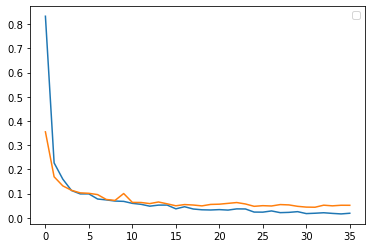

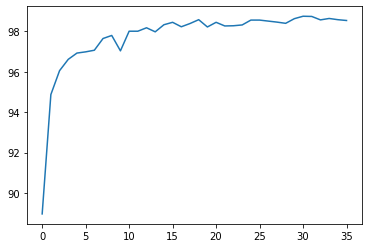

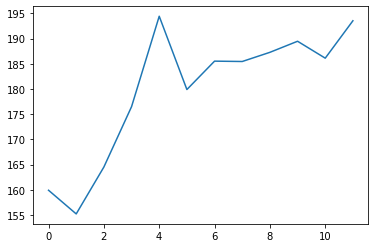

In [19]:
plt.plot(LeASLNN.train_loss)
plt.plot(LeASLNN.test_loss)
plt.legend()
plt.show()
plt.plot(LeASLNN.test_accuracy)
plt.show()
plt.plot(LeASLNN.train_time)
plt.show()

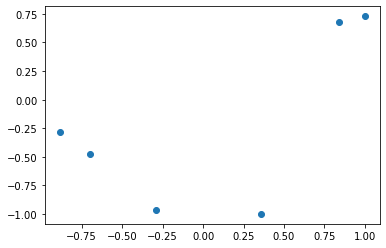

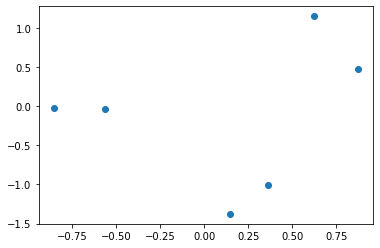

In [12]:
points = LeASLNN.NN[4].NN[3].shifts.detach().to("cpu").numpy()
initial_points = LeASLNN.NN[4].NN[3].initial.detach().to("cpu").numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

In [4]:
from Models import LeDepthNet

input_shape = (100, 1, 28, 28)

LeDepthNN = LeDepthNet(input_shape, 10, device)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─Depth_wise_block: 2-5             [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        226
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─Tanh: 2-10                        [100, 120]                --
│    └─Li

In [5]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(LeDepthNN.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [6]:
leDepthStats = train_NN(LeDepthNN, train_dataloader,
        test_dataloader, epochs=4, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.479
test_loss: 0.139, test_accuracy: 95.8
[1,   400] train_loss: 0.128
test_loss: 0.090, test_accuracy: 97.2
[1,   600] train_loss: 0.089
test_loss: 0.078, test_accuracy: 97.61
[2,   200] train_loss: 0.051
test_loss: 0.050, test_accuracy: 98.38
[2,   400] train_loss: 0.054
test_loss: 0.051, test_accuracy: 98.39
[2,   600] train_loss: 0.052
test_loss: 0.045, test_accuracy: 98.59
[3,   200] train_loss: 0.032
test_loss: 0.039, test_accuracy: 98.73
[3,   400] train_loss: 0.032
test_loss: 0.040, test_accuracy: 98.66
[3,   600] train_loss: 0.034
test_loss: 0.037, test_accuracy: 98.71
[4,   200] train_loss: 0.025
test_loss: 0.037, test_accuracy: 98.75
[4,   400] train_loss: 0.024
test_loss: 0.035, test_accuracy: 98.76
[4,   600] train_loss: 0.025
test_loss: 0.035, test_accuracy: 98.77


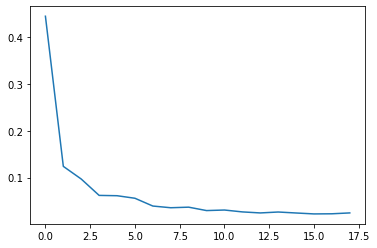

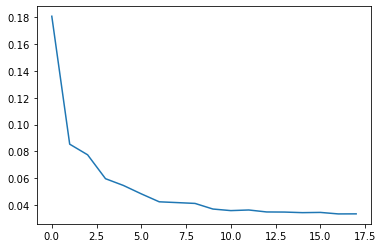

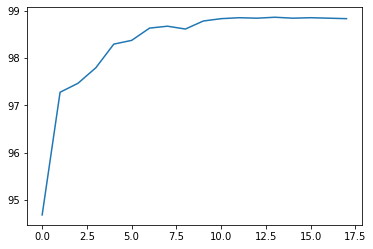

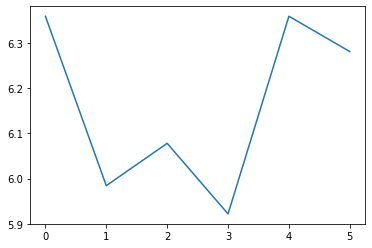

In [16]:
plt.plot(leDepthStats[0])
plt.show()
plt.plot(leDepthStats[1])
plt.show()
plt.plot(leDepthStats[2])
plt.show()
plt.plot(leDepthStats[3])
plt.show()